<h1>Deep learning project 8DM20 CSMIA</h1>

<h4>Group members:</h4>
O. Akdag - 0842508 <br>
T.P.A. Beishuizen - 0791613 <br>
A.S.A. Eskelinen - 1224333 <br>
J.H.A. Migchielsen - 0495058 <br>
L. van den Wildenberg - 0844697 <br>

In [2]:
# Import all used packages (unused packages are commented out so far)
import os
from PIL import Image as PIL_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.feature_extraction import image as sklearn_image
#matplotlib inline
import theano
import lasagne
import time
import random
import math
random.seed(0)

C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Before every thing can be done, at first the data images have to be read and be made in useable data types.

In [81]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(PIL_image.open(image_path))
        
    return images

#The function that converts the channels in the images from RGB to gray
#and makes matrices from the images
def convertImageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('L'))
        image_matrices.append(image_matrix)
        
    return image_matrices

#The function that prepares the image matrices to the data used for machine learning
def prepareMachineLearningData(image_matrix, output_matrix, mask_matrix, kernel_size, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrix, np.ndarray) and 
            isinstance(output_matrix, np.ndarray) and 
            isinstance(mask_matrix, np.ndarray)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if mask_removal != 'pixel' and mask_removal != 'patch':
        raise Exception("Unknown mask data removal type")
    
    if not (image_matrix.shape == output_matrix.shape == mask_matrix.shape):
        raise Exception("The images are not the same size")
    
    if np.unique(mask_matrix).shape[0] != 2:
        raise Exception("The mask matrix does not consist of only 2 values")
    
    #Creates a matrix with all possible patches
    all_image_patches = sklearn_image.extract_patches_2d(image_matrix,(kernel_size,kernel_size))
    all_image_patches = np.expand_dims(all_image_patches, axis=1)
    
    if kernel_size % 2 != 0:
         # Creates an array with all output
        mat_red = (kernel_size - 1) / 2
        reduced_output_matrix = output_matrix[ mat_red : -  mat_red,  mat_red : -  mat_red]
        complete_output_array = reduced_output_matrix.reshape(-1)

        new_mask_matrix = mask_matrix.copy()
        
        # Makes some additional mask values zero on the edge of the mask
        if mask_removal == 'patch':
            for i in range(mat_red, mask_matrix.shape[0] -  mat_red + 1):
                for j in range(mat_red, mask_matrix.shape[1] -  mat_red + 1):
                    if 0 in mask_matrix[i - mat_red : i + mat_red + 1, j - mat_red: j + mat_red + 1]:
                        new_mask_matrix[i,j] = 0;
        
        # Creates an array with all mask locations
        reduced_mask_matrix = new_mask_matrix[ mat_red : -  mat_red, mat_red : -  mat_red]
        mask_array = reduced_mask_matrix.reshape(-1)
    
    else:
        # Creates an array with all output
        mat_red = (kernel_size) / 2
        reduced_output_matrix = output_matrix[mat_red - 1: -  mat_red,  mat_red - 1: -  mat_red]
        complete_output_array = reduced_output_matrix.reshape(-1)

        new_mask_matrix = mask_matrix.copy()
        
        # Makes some additional mask values zero on the edge of the mask
        if mask_removal == 'patch':
            for i in range(mat_red - 1, mask_matrix.shape[0] -  mat_red + 1):
                for j in range(mat_red - 1, mask_matrix.shape[1] -  mat_red + 1):
                    if 0 in mask_matrix[i - mat_red + 1 : i + mat_red + 1, j - mat_red + 1: j + mat_red + 1]:
                        new_mask_matrix[i,j] = 0;
                     
        # Creates an array with all mask locations
        reduced_mask_matrix = new_mask_matrix[mat_red - 1: - mat_red, mat_red - 1: - mat_red]
        mask_array = reduced_mask_matrix.reshape(-1) 

    image_patches = []
    output_array = []
    
    # Reduces the number of patches and output to only the mask values
    for i in range(len(mask_array)):
        if mask_array[i] != 0:
            image_patches.append(all_image_patches[i,:,:])
            output_array.append(complete_output_array[i])
        
    
    # Return the image patches and the output array
    return image_patches, output_array

# Prepare multiple images at once
def prepareMultipleImages(image_matrices, output_matrices, mask_matrices, kernel_size = 25, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrices, list) and 
            isinstance(output_matrices, list) and 
            isinstance(mask_matrices, list)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (len(image_matrices) == len(output_matrices) == len(mask_matrices)):
        raise Exception("The images are not the same size")
    
    image_patches = [] 
    output_arrays = []
    
    # Finds the output data per image
    for i in range(len(image_matrices)):
        new_image_patches, new_output_array = prepareMachineLearningData(image_matrices[i], output_matrices[i], mask_matrices[i], 
                                                                         kernel_size = kernel_size, mask_removal = mask_removal)
        image_patches.append(new_image_patches)
        output_arrays.append(new_output_array)
        
        #Print progress for showing time consumption
        print"Progress: {} %".format(100*(i+1)/len(image_matrices)),
              
    return image_patches, output_arrays

def createVesselImage(output_array, mask_matrix, kernel_size):
    #Check if input is correct
    if not isinstance(output_array, list) or not isinstance(mask_matrix, np.ndarray) or not isinstance(kernel_size, int):
        raise Exception("Not the right input variables")
    
    #Create an output_matrix for the output array
    #output_matrix = np.array(mask_matrix)
    output_matrix = np.zeros(mask_matrix.shape)
    output_loc = 0
    
    # Take into account that mask pixels too close to the border are lost due to inability to make patches
    edge_corr = math.ceil(kernel_size / 2) - 1
    
    # Check every pixel within the mask for a vessel pixel
    for i in range(mask_matrix.shape[0] - kernel_size + 1):
        for j in range(mask_matrix.shape[1] - kernel_size + 1):
            if mask_matrix[i + edge_corr, j + edge_corr] == 255:
                output_matrix[i + edge_corr, j + edge_corr] = output_array[output_loc]
                output_loc += 1
                
    return output_matrix 

All images are loaded and immediately made into matrices for further computation

In [23]:
# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = convertImageToMatrix(test_manual1_images)
test_manual2_matrices = convertImageToMatrix(test_manual2_images)
test_raw_matrices = convertImageToMatrix(test_raw_images)
test_mask_matrices = convertImageToMatrix(test_mask_images)

# All training image lists
training_manual1_images = loadData('training', '1st_manual')
training_raw_images = loadData('training', 'images')
training_mask_images = loadData('training', 'mask')

# Making matrices of the training images to work with
training_manual1_matrices = convertImageToMatrix(training_manual1_images)
training_raw_matrices = convertImageToMatrix(training_raw_images)
training_mask_matrices = convertImageToMatrix(training_mask_images)

The matrices are then used for further preprocessing to retrieve the suitable data for machine learning

In [82]:
#Choose the number of images
nr_images = 2

# Prepares the data for machine learning: X = image_patches, y = output_array
# Both are a list with the patches and output_arrays for multiple images (the number chosen before)
image_patches, output_array = prepareMultipleImages(test_raw_matrices[0:nr_images], test_manual1_matrices[0:nr_images], 
                                                     test_mask_matrices[0:nr_images], kernel_size = 32, mask_removal = 'pixel')

image_patches2, output_array2 = prepareMultipleImages(test_raw_matrices[0:nr_images], test_manual1_matrices[0:nr_images], 
                                                     test_mask_matrices[0:nr_images], kernel_size = 32, mask_removal = 'patch')

Progress: 50 % Progress: 100 % Progress: 50 % Progress: 100 %


The following code is just to show how the data set is built up. There are patches of 25x 25. These values either correspond to a vene pixel or not.

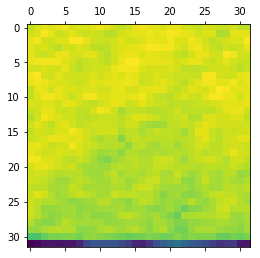

Should be vene pixel? 0 (255 is yes, 0 is no)


In [83]:
image_number = 1
pixel = -1 #35620 #35645


np.asarray(image_patches[1]).shape

plt.matshow(image_patches2[image_number][pixel][0])
plt.show()

print("Should be vene pixel? " + str(output_array[image_number][pixel]) + " (255 is yes, 0 is no)")

224807
224807


C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


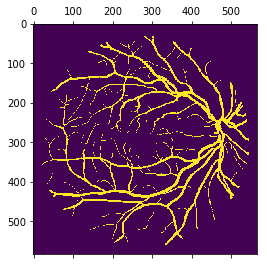

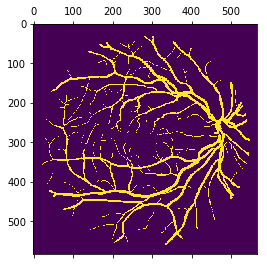

In [132]:
output_matrix = createVesselImage(output_array[1], test_mask_matrices[1], 32)

plt.matshow(output_matrix)
plt.matshow(test_manual1_matrices[1])
plt.show()

In [75]:
EXX_patches = sklearn_image.extract_patches_2d(np.zeros((5,5)),(2,2))
print(len(EXX_patches))
smaller_EXX_patches = np.zeros((5,5))[0:-1,:]
print(smaller_EXX_patches.shape)

16
(4L, 5L)
